# Run the MNE BIDS Pipeline

## Steps for Running this Notebook

1. Clone the Git repository of this project. (Since the Notebook is available, this step should be fulfilled.)
2. Run preparatory notebook `prepare_data.ipynb` to install dependencies, download, and patch the dataset.
3. Run the pipeline with checkups by running this notebook.

## Header: Load Modules, Set and Load Parameters, Define Functions
Prior to running the main steps of the pipeline, multiple steps need to be performed:

- Load modules:
  Load modules needed for all (e. g. MNE BIDS pipeline), or few (e. g. `typing`) pipeline steps. Load custom modules (e. g. `ica_helpers`)
- Set and load parameters:
  Set the relative (or absolute) path to the pipeline configuration, and load the configuration from the file.

In [1]:
# import basic EEG manipulation and analysis modules
import mne_bids_pipeline

# import function to load configuration from file
from mne_bids_pipeline._config_import import _import_config as getConfig

# allow for accessing the command line within Python
import sys

In [2]:
# allow for checkup plots based on data stored in files
import mne # module for e.g. loading raw, or epoched signals from file
import matplotlib.pyplot as plt # plotting module

In [3]:
# set the file path of the main configuration file
config_path = "./mne-bids/config/mne-bids-pipeline.py"

In [4]:
# for checkups, set the command for listing files directly or in a directory
ls_command = 'dir' if sys.platform.startswith('win') else 'ls'

In [5]:
# define a function which gets used in application of the ICA results to the raw data
import src.tools.ica_helpers as ih

In [6]:
# custom module for plotting
import src.tools.plot_power as pp

## Pipeline

Start the pipeline running these steps:

- `preprocessing/_01_data_quality`
- `preprocessing/_04_frequency_filter`
- `preprocessing/_05_make_epochs`
- `preprocessing/_06a_run_ica`, ica labelling, `preprocessing/_07a_apply_ica`
- `preprocessing/_08_ptp_reject`
- `sensor`
- `source`

Each of the steps contains one or more checkups for validating the results of the step.

Since the step names of MNE BIDS pipeline were changed after the start of this notebooks creation, the step names should get updated for use with another module version.
The simplest version could be to run all pre-processing by running `preprocessing` instead of the minor steps `preprocessing/_0*_*`.

### Initial Setup

First, the selected pipeline configuration gets loaded.
Few of its entries get printed as checkup.

Then, the initial preparations for running the pipeline get started: configuration loading and directory creation.
This also is followed by a checkup.

In [7]:
# load configured settings from file
cfg = getConfig(
    config_path=config_path
)

In [8]:
# checkup: print config contents
print(
    "study name:\t\t", cfg.study_name, 
    "\nsubjects dir:\t\t", cfg.subjects_dir, 
    "\ntask:\t\t\t", cfg.task, 
    "\nconditions:\t\t", cfg.conditions, 
    "\nraw resample sfreq:\t", cfg.raw_resample_sfreq,
    "\nl/h freq:\t\t", [cfg.l_freq, cfg.h_freq],
    "\nica max iterations:\t", cfg.ica_max_iterations, 
    "\nica n components:\t", cfg.ica_n_components, 
    "\ndecoding csp freqs:\t", cfg.decoding_csp_freqs
)

study name:		 EEG-course-project 
subjects dir:		 ../data/ds003702/ 
task:			 SocialMemoryCuing 
conditions:		 ['avatar', 'sticks'] 
raw resample sfreq:	 100.0 
l/h freq:		 [1.0, 30.0] 
ica max iterations:	 3000 
ica n components:	 0.95 
decoding csp freqs:	 {'theta': [3, 7], 'alpha': [8, 12]}


In [9]:
# checkup: # print end of path to the stored bids root path
cfg.bids_root.parts[-2:]

('data', 'ds003702')

In [10]:
curr_steps = "init"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:52:17│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:17│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:17│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:17│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:17│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)


In [11]:
# checkup: check, whether output directory was created
#          The derivatives directory should exist and contain a subfolder per selected subject.
#          The subjects subfolders should be empty if no data were alread generated.
curr_bids_root = cfg.bids_root.__str__()
!"{ls_command}" "{curr_bids_root}"/derivatives/mne-bids-pipeline/

_cache			  sub-13  sub-26  sub-39
dataset_description.json  sub-14  sub-27  sub-40
sub-01			  sub-15  sub-28  sub-41
sub-02			  sub-16  sub-29  sub-43
sub-03			  sub-17  sub-30  sub-44
sub-04			  sub-18  sub-31  sub-45
sub-05			  sub-19  sub-32  sub-46
sub-06			  sub-20  sub-33  sub-48
sub-07			  sub-21  sub-34  sub-49
sub-09			  sub-22  sub-35  sub-50
sub-10			  sub-23  sub-36  task-SocialMemoryCuing_log.xlsx
sub-11			  sub-24  sub-37  task-SocialMemoryCuing_log.xlsx.lock
sub-12			  sub-25  sub-38


### Pre-processing: Data Quality
Next, an investsigation on the provided data set is started.
Per subject, a report gets created.
A simple checkup is used to print an excerpt of one of the checkups.

In [12]:
curr_steps = "preprocessing/_01_data_quality"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:52:19│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:19│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:20│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_01_data_quality ──────────────────────────────────────
│00:52:22│ ✅ sub-05 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-03 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-02 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-01 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-04 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-07 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-09 Computation unnecessary (cached) …
│00:52:22│ ✅ sub-11 Computation unnecessary (cac

In [13]:
# checkup: print some content which was written to file
import h5py

# set filename
curr_checkup_filename = f"{curr_bids_root}/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_report.h5"

# print file name if file exists
!"{ls_command}" "{curr_checkup_filename}" | xargs basename

# import data
curr_checkup_h5file = h5py.File(curr_checkup_filename, 'r')
curr_html_length = len(curr_checkup_h5file["mnepython/key__content/idx_0/key_html"])
htmlContent = ''.join([ chr(curr_checkup_h5file["mnepython/key__content/idx_0/key_html"][idx] ) for idx in range(curr_html_length) ])
curr_checkup_h5file.close()
# print excerpt of html output
print(f"[...]\n{htmlContent[2500:2850]}\n[...]")

# print hint regarding extra data
print("\n===\nmore data: see at..")
# for more data, open the written html report file
!"{ls_command}" ./"{cfg.bids_root.parts[-2]}"/"{cfg.bids_root.parts[-1]}"/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_report.html

sub-01_task-SocialMemoryCuing_report.h5
[...]
</details>
        <details open>
            <summary><strong>Data</strong></summary>
            <table class="table table-hover table-striped table-sm table-responsive small">
                
                <tr>
                    <th>Sampling frequency</th>
                    <td>500.00 Hz</td>
                </tr>
                
       
[...]

===
more data: see at..
./data/ds003702/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_report.html


Since this checkup prints a part of the HTML source code of the data quality analysis output, the previously run step has exported data to this HTML file.
These results can get reviewed in the HTML file together with other pipeline outputs.

### Pre-processing: Skipped Steps
These two steps get ignored in the selected pipeline.

In [14]:
curr_steps = "preprocessing/_02_head_pos"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:52:26│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:26│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:26│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_02_head_pos ──────────────────────────────────────────
│00:52:26│ ⏩ Skipping …
└────────┴ done (1s)


In [15]:
# checkup: not needed, since this step was skipped

In [16]:
curr_steps = "preprocessing/_03_maxfilter"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:52:28│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:28│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:28│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_03_maxfilter ─────────────────────────────────────────
│00:52:28│ ⏩ Skipping …
└────────┴ done (1s)


In [17]:
# checkup: not needed, since this step was skipped

### Pre-processing: Band Pass Filter etc.
The frequency filter step applies multiple linear, time invariant filters.
An example is the applied band pass filter with cutoff frequencies at 1.0 Hz and 30.0 Hz.
The lowpass filter removes most high frequency noise from the data, including D/C noise. 
The highpass filter does some implicit detrending, and is a good practice in preparation for the ICA artefact removal.

We decided for such a narrow filter band, as our analysis is based on more narrow bandwidths.
These frequency bands in our analysis are alpha and theta oscillations.
Both bands cutoff frequencies are in the range of 3 Hz to 12 Hz. 

Thus, removing the energy of frequency bands below 1 Hz and above 30 Hz should not remove relevant information for this analysis.
Furthermore, the lowpass frequency of 30 Hz allows for downsampling the signals with sample rates of at least 60 Hz.

This is based on the Nyquist theoreme: The sample rate should be at least twice as high as the highest frequency given in the signal.
If this is not fulfilled, by aliasing the energy of the signal at frequencies higher than the Nyquist frequency gets added to the downsampled signal at other frequencies.

Since the filter curve is expected to be non-perfect in the sense of implementing a step from 0 dB amplification to -∞ dB at the cutoff frequency, a decreasing energy over the frequency above the cutoff frequency is expected.
Based on this energy decay over the frequency, we chose a higher sample rate of 100 Hz to get a slightly improved signal to noise ratio compared to a lower sample rate.

The application of this pre-processing step is followed by a plot of the resulting spectral density of the power over the frequency for a single subject.
This plot shows the effectiveness of the band pass filter.
Additionally, the existence of the filtered signal file is proven.

In [18]:
curr_steps = "preprocessing/_04_frequency_filter"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:52:30│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:30│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:30│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_04_frequency_filter ──────────────────────────────────
│00:52:32│ ✅ sub-02 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-01 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-07 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-09 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-10 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-06 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-03 Computation unnecessary (cached) …
│00:52:32│ ✅ sub-11 Computation unnecessary (cac

In [19]:
%matplotlib widget

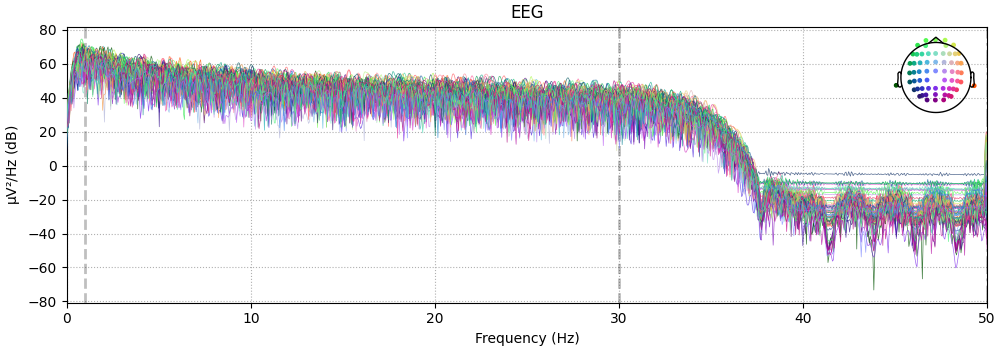

checkup plot showing reduced bandwidth of eeg signals


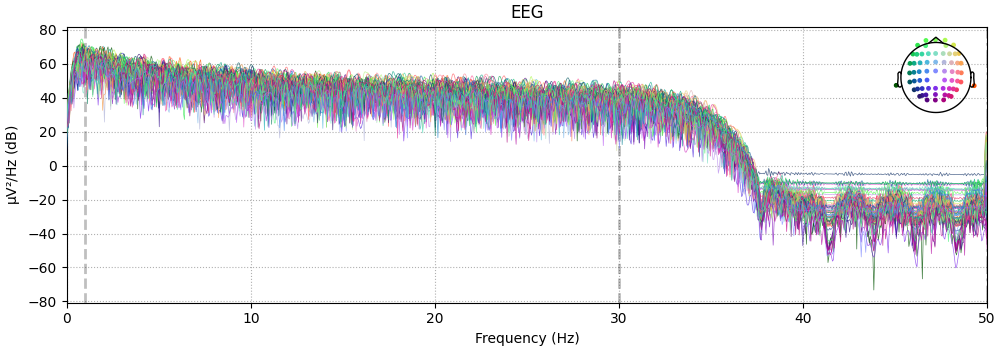

In [20]:
# checkup: print spectrum of original and filtered signals, print sample rate of new raw data file
curr_checkup_filename = f"{curr_bids_root}/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_proc-filt_raw.fif"
curr_checkup_raw_filtered = mne.io.read_raw_fif(curr_checkup_filename, preload=True)
curr_checkup_raw_filtered.plot_psd()
print("checkup plot showing reduced bandwidth of eeg signals")

This checkup shows multiple results:

- For low frequencies, the power per frequency bin gets reduced by approximately 30-40 dB between 1 Hz and 0 Hz compared to constant power over frequency.
    - ⇒ The high pass filter seems to work.
- For high frequencies, the power per frequency bin gets reduced by about 60 dB compared to constant power over frequency in a third octave above the upper cutoff frequency at 30 Hz.
    - ⇒ The low pass filter seems to work.
- The 2d electrode position map (top right corner) seems to be somewhat valid.
    - ⇒ The electrode positions seem to be loaded correctly.
- The spectral power density seems to be similar for all electrodes for this subject.
    - ⇒ At first glance, the electrodes seem to have been mounted in a similar way. This could indicate a correct use of the EEG measurement technology by trained personal.

In [21]:
# checkup: print file name if the processed file exists
curr_subject_path = f"{curr_bids_root}/derivatives/mne-bids-pipeline/sub-01/eeg"
!"{ls_command}" "{curr_subject_path}"/sub-01_task-SocialMemoryCuing_proc-filt_raw.fif | xargs basename

sub-01_task-SocialMemoryCuing_proc-filt_raw.fif


The file seems to exist. This indicates a correctly downloaded and extracted dataset at the expected path.

### Pre-processing: Split Signal to Epochs
In the next step, the signal gets split to epochs per subject.
This extraction is followed by the plot of an example subject showing all epochs.

In [22]:
curr_steps = "preprocessing/_05_make_epochs"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:52:36│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:52:36│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:52:37│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_05_make_epochs ───────────────────────────────────────
│00:52:39│ ✅ sub-01 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-04 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-07 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-05 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-09 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-10 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-11 Computation unnecessary (cached) …
│00:52:39│ ✅ sub-12 Computation unnecessary (cac

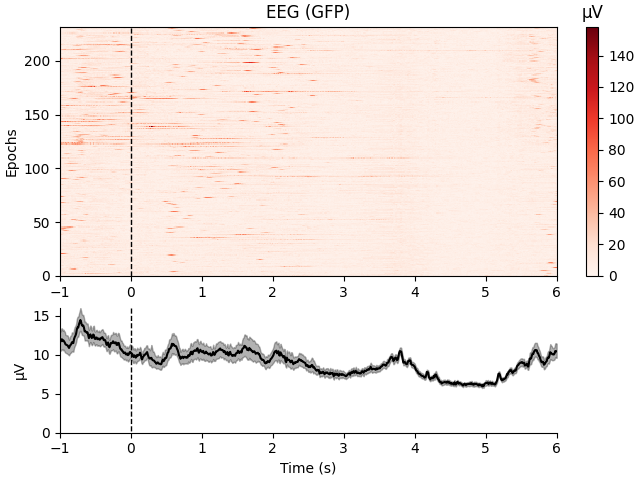

[<Figure size 640x480 with 3 Axes>]

In [23]:
# checkup: plot epochs
curr_checkup_epochs = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs)

### Pre-processing: ICA

Running the ICA is split to three steps:

- component analysis
- component labelling (`good` vs. `bad`)
- signal cleaning

#### ICA: Analysis

For the analysis, per subject the algorithm selected in the configuration file gets run.
Here, extended infomax is selected, which follows peak to peak rejection (PTP).
Since with low threshold the PTP does not return enough epochs, a high threshold is selected matching the default pipeline threshold.
More accurate PTP is later run on the ICA cleaned epoch signals.

The analysis is followed by a plot of unlabelled components.

In [24]:
curr_steps = "preprocessing/_06a_run_ica"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│02:33:24│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│02:33:24│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│02:33:25│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_06a_run_ica ──────────────────────────────────────────
│02:33:27│ 🚫 sub-07 Output file hash mismatch, will recompute …
│02:33:27│ 🚫 sub-01 Output file hash mismatch, will recompute …
│02:33:27│ ⏳️ sub-01 Loading filtered raw data from sub-01_task-SocialMemoryCuing_proc-filt_raw
│02:33:27│ ⏳️ sub-01 No ECG or magnetometer channels are present. Cannot automate artifact detection for ECG
│02:33:27│ 🚫 sub-04 Output file hash mismatch, will recompute …
│02:33:27│ 🚫 sub-06 Output file hash

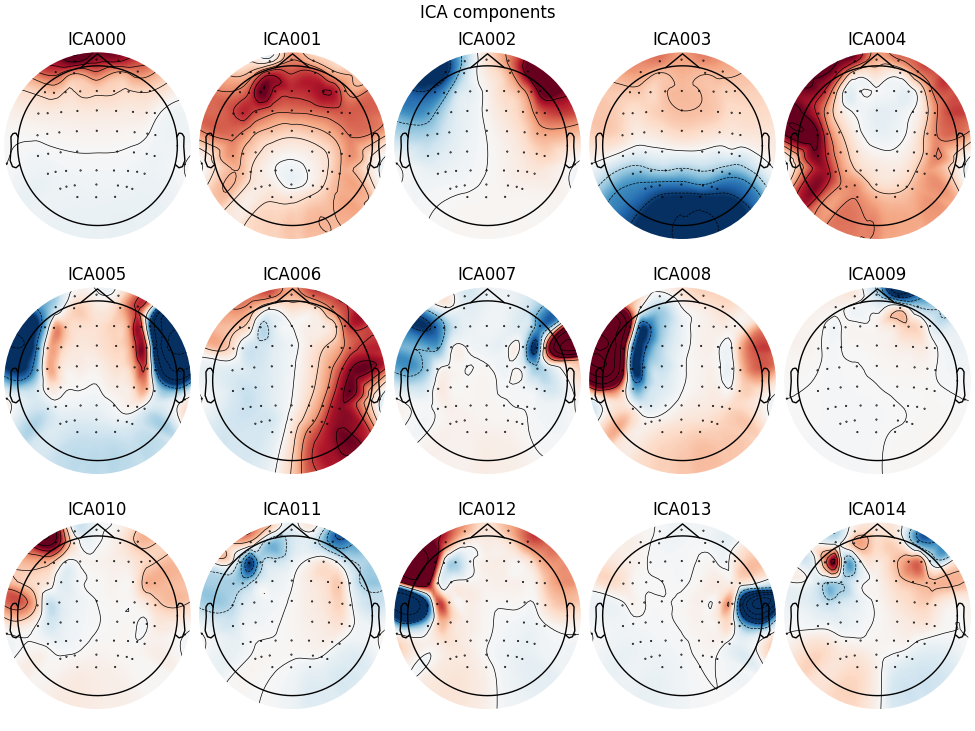

checkup: ICA component plots of the selected subject


In [25]:
# checkup: plot ica components
curr_checkup_ica = mne.preprocessing.read_ica(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_ica.fif")
curr_checkup_ica.apply(curr_checkup_raw_filtered)
curr_checkup_ica.plot_components(inst=curr_checkup_raw_filtered)
print("checkup: ICA component plots of the selected subject")

#### ICA: Labelling

For automatic labelling of the components, the ICA label algorithms provided in the MNE framework get applied.
The verbose version of the custom functions output is returned by this custom function.
This is is followed by the content of a single subjects updated component label file.

In [25]:
ih.update_ica_labels(cfg=cfg, do_print_verbose=True)



SUBJECT: 01
<ICA | epochs decomposition, method: infomax (fit in 3000 iterations on 148612 samples), 15 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

resulting predictions: [0.886306   0.5692941  0.998059   0.94482005 0.46491617 0.2724525
 0.6553011  0.38906202 0.5948534  0.29512608 0.5099864  0.6157444
 0.55490154 0.33994666 0.38270986]

resulting labels:      ['eye blink', 'brain', 'eye blink', 'brain', 'brain', 'muscle artifact', 'brain', 'channel noise', 'brain', 'channel noise', 'brain', 'eye blink', 'brain', 'brain', 'eye blink']

old tsv file content:
    component type            description status  status_description
0           0  ica  Independent Component   good                 NaN
1           1  ica  Independent Component   good                 NaN
2           2  ica  Independent Component   good                 NaN
3           3  ica  Independent Component   good                 NaN
4           4  ica  Independent Co

In [26]:
# checkup: print list of components given in updated …_proc-ica+components.tsv file
!cat "{curr_subject_path}/sub-01_task-SocialMemoryCuing_proc-ica_components.tsv"
# This file should contain a status like "bad" for eye blinks, or "good" for brain activity, as it is indicated above and visible in the ICA component plots.

component	type	description	status	status_description
0	ica	Independent Component	bad	
1	ica	Independent Component	good	
2	ica	Independent Component	bad	
3	ica	Independent Component	good	
4	ica	Independent Component	good	
5	ica	Independent Component	bad	
6	ica	Independent Component	good	
7	ica	Independent Component	bad	
8	ica	Independent Component	good	
9	ica	Independent Component	bad	
10	ica	Independent Component	good	
11	ica	Independent Component	bad	
12	ica	Independent Component	good	
13	ica	Independent Component	good	
14	ica	Independent Component	bad	


#### ICA: Cleaning
Based on the component labels, the signals of the corresponding subject get cleaned.

The resulting epoch signals get plotted in comparison to the not-ICA-cleaned epoch signals.
The amplitude of the epoch signals is visualised based on the colourbar on the right hand side.
This colourbar is independent per plot.

In [27]:
curr_steps = "preprocessing/_07a_apply_ica"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:56:25│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:56:25│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:56:25│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_07a_apply_ica ────────────────────────────────────────
│00:56:27│ ⏳️ sub-01 Input: sub-01_task-SocialMemoryCuing_epo.fif
│00:56:27│ ⏳️ sub-01 Output: sub-01_task-SocialMemoryCuing_proc-ica_epo.fif
│00:56:27│ ⏳️ sub-02 Input: sub-02_task-SocialMemoryCuing_epo.fif
│00:56:27│ ⏳️ sub-02 Output: sub-02_task-SocialMemoryCuing_proc-ica_epo.fif
│00:56:27│ ⏳️ sub-04 Input: sub-04_task-SocialMemoryCuing_epo.fif
│00:56:27│ ⏳️ sub-06 Input: sub-06_task-SocialMemoryCuing_epo.fif
│00:56:27│ ⏳️ sub

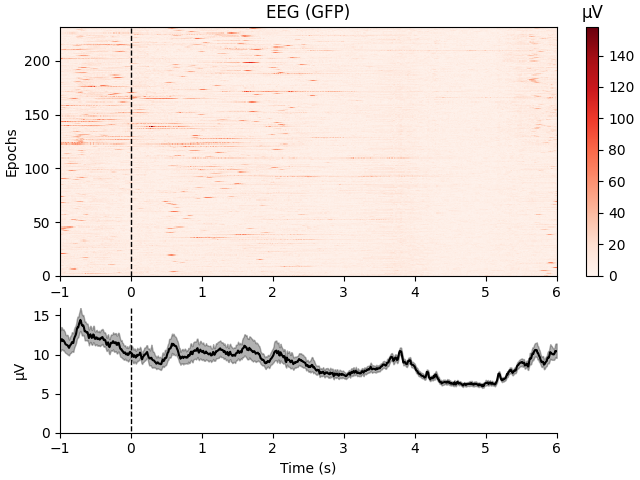

checkup: original (top) vs. ica-applied (bottom) epochs


In [28]:
# checkup: plot original (conventionally filtered) epochs
curr_checkup_epochs = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs)
print("checkup: original (top) vs. ica-applied (bottom) epochs")

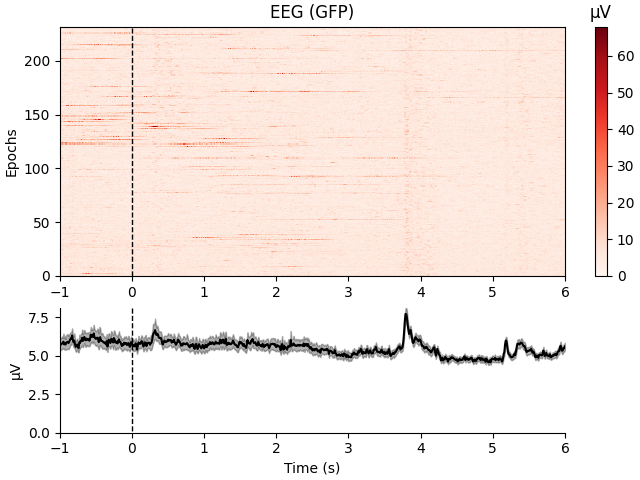

checkup: original (top) vs. ica-applied (bottom) epochs; Compare the scale in μV.


In [29]:
# checkup: plot ICA-corrected epochs
curr_checkup_epochs_ica = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_proc-ica_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs_ica)
print("checkup: original (top) vs. ica-applied (bottom) epochs; Compare the scale in μV.")

### Pre-processing: Peak to Peak Rejection
The last step in the pre-processing is the peak to peak rejection.
This also is followed by plots comparing the original epoch signals after basic filtering to the ICA and PTP filtered epoch signals.

In [30]:
curr_steps = "preprocessing/_08_ptp_reject"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│00:58:30│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│00:58:30│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│00:58:31│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_08_ptp_reject ────────────────────────────────────────
│00:58:31│ ⏳️ sub-01 Input:  sub-01_task-SocialMemoryCuing_proc-ica_epo.fif
│00:58:31│ ⏳️ sub-01 Output: sub-01_task-SocialMemoryCuing_proc-clean_epo.fif
│00:58:31│ ⏳️ sub-01 Generating rejection thresholds using autoreject …
│00:58:35│ ⏳️ sub-01 Using PTP rejection thresholds: {'eeg': 0.00011415776180418859}
│00:58:35│ ⏳️ sub-01 Adding cleaned epochs to report.
│00:58:38│ ⏳️ sub-01 Adding config and sys info to report
│00:58:41│

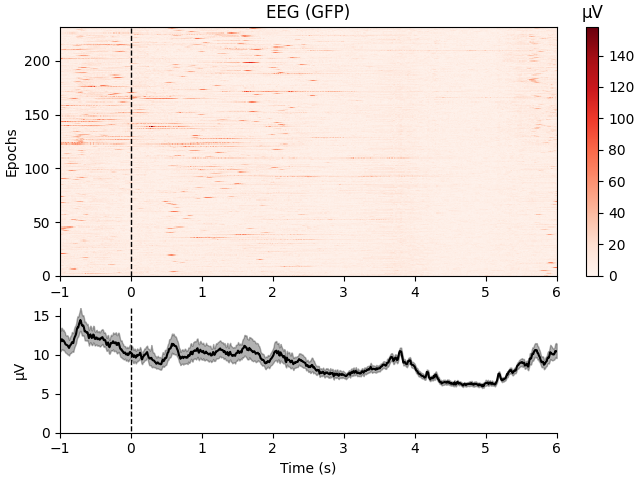

checkup: original epochs


In [31]:
# checkup: plot original (conventionally filtered) epochs
curr_checkup_epochs = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs)
print("checkup: original epochs")

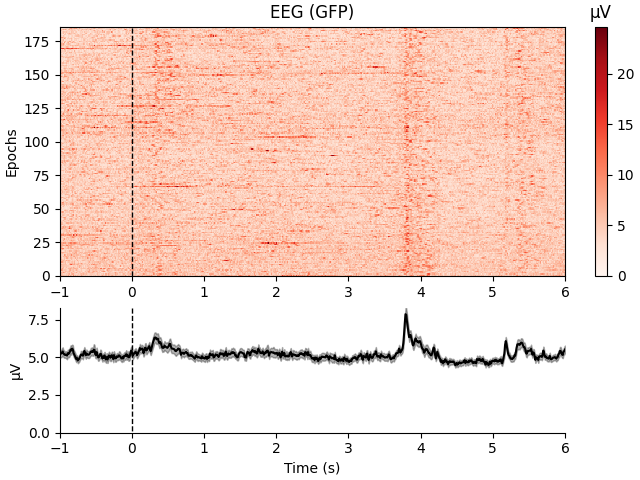

checkup: original (top) vs. cleaned epochs (bottom)


In [32]:
# checkup: plot cleaned epochs
curr_checkup_epochs_ptp = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_proc-clean_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs_ptp)
print("checkup: original (top) vs. cleaned epochs (bottom)")

## Analysis
The pre-processing steps get followed by the analysis steps.

### Analysis: Sensor

In [36]:
curr_steps = "sensor"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│01:50:11│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│01:50:12│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│01:50:12│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ sensor/_01_make_evoked ──────────────────────────────────────────────
│01:50:13│ ✅ sub-04 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-02 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-01 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-07 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-09 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-11 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-10 Computation unnecessary (cached) …
│01:50:13│ ✅ sub-12 Computation unnecessary (cac

### Analysis: Source Space Analysis

In [37]:
curr_steps = "source"
!mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│01:50:24│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline_tests.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│01:50:24│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│01:50:25│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ source/_01_make_bem_surfaces ────────────────────────────────────────
│01:50:25│ ⏩ Skipping, BEM surface extraction not needed for MRI template …
└────────┴ done (1s)
┌────────┬ source/_02_make_bem_solution ────────────────────────────────────────
│01:50:25│ ⏩ Skipping, BEM solution computation not needed for MRI template …
└────────┴ done (1s)
┌────────┬ source/_03_setup_source_space ───────────────────────────────────────
│01:50:26│ 🔍 sub-fsaverage Computation unnecessary (output files exist) …
└

## Files per Step

To allow for additional investigation on the processed signals, the following list contains the exported files per step for the first subject.
These file names shall also help to interprete the check ups performed by printing file names of existing files.

- `preprocessing/_01_data_quality`
    ```
    sub-01_task-SocialMemoryCuing_report.h5
    sub-01_task-SocialMemoryCuing_report.h5.lock
    sub-01_task-SocialMemoryCuing_report.html
    ```
- `preprocessing/_04_frequency_filter`
    ```
    sub-01_task-SocialMemoryCuing_proc-filt_raw.fif
    ```
- `preprocessing/_05_make_epochs`
    ```
    sub-01_task-SocialMemoryCuing_epo.fif
    ```
- `preprocessing/_06a_run_ica`

    ```
    sub-01_task-SocialMemoryCuing_ica.fif
    sub-01_task-SocialMemoryCuing_proc-ica_components.tsv
    sub-01_task-SocialMemoryCuing_proc-ica+components_report.html
    ```
- ica labelling: no new file (just changes of `*.tsv` file)
- `preprocessing/_07a_apply_ica`
    ```
    sub-01_task-SocialMemoryCuing_proc-ica_epo.fif
    sub-01_task-SocialMemoryCuing_proc-ica_report.html
    ```
- `preprocessing/_08_ptp_reject`
    ```
    sub-01_task-SocialMemoryCuing_proc-clean_epo.fif
    ```
- `sensor`
    ```
    sub-01_task-SocialMemoryCuing_ave.fif
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+FullEpochs+rocauc_decoding.mat
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+FullEpochs+rocauc_decoding.tsv
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+TimeByTime+rocauc_decoding.mat
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+TimeByTime+rocauc_decoding.tsv
    
    sub-01_task-SocialMemoryCuing_itc+avatar+tfr.h5
    sub-01_task-SocialMemoryCuing_itc+sticks+tfr.h5
    sub-01_task-SocialMemoryCuing_power+avatar+tfr.h5
    sub-01_task-SocialMemoryCuing_power+sticks+tfr.h5
     
    sub-01_task-SocialMemoryCuing_cov.fif
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+CSP+rocauc_decoding.xlsx
    ```
- `source`
    ```
    sub-01_task-SocialMemoryCuing_fwd.fif
    sub-01_task-SocialMemoryCuing_trans.fif
    ```


## Further Comparison

In [35]:
subject_str = "01"
data_path = cfg.bids_root
cues_list = ['avatar', 'sticks']
bands_list = ['alpha', 'theta']
time_ranges = [[2, 3], [3.6, 4]]
# '{data}/derivatives/mne-bids-pipeline/sub-{sub}/eeg/sub-{sub}_task-SocialMemoryCuing_power+{cue}+tfr.h5'

In [51]:
for idx_cue in range(len(cues_list)):
    for idx_band in range(len(bands_list)):
        idx_band = 0 # todo: first run pipeline for other frequency band
        for idx_time in range(len(time_ranges)):
            curr_filename_str = f"plot_power_sub-{subject_str}_{cues_list[idx_cue]}_" + \
                f"{bands_list[idx_band]}_" + \
               f"{time_ranges[idx_time][0]:01.1f}-{time_ranges[idx_time][1]:01.1f}.png"
            print(curr_filename_str)
            pp.plotPower(
                config_path = config_path,
                subject = subject_str,
                cue = cues_list[idx_cue],
                band = bands_list[idx_band],
                time_range = time_ranges[idx_time],
                filename = curr_filename_str
            )

plot_power_sub-01_avatar_alpha_2.0-3.0.png
plot_power_sub-01_avatar_alpha_3.6-4.0.png
plot_power_sub-01_avatar_alpha_2.0-3.0.png
plot_power_sub-01_avatar_alpha_3.6-4.0.png
plot_power_sub-01_sticks_alpha_2.0-3.0.png
plot_power_sub-01_sticks_alpha_3.6-4.0.png
plot_power_sub-01_sticks_alpha_2.0-3.0.png
plot_power_sub-01_sticks_alpha_3.6-4.0.png
